In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.42s/it]


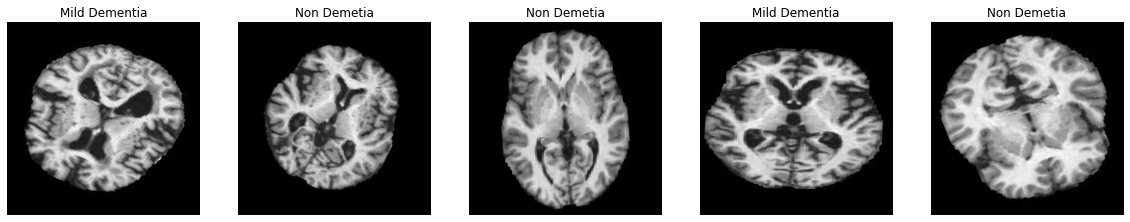

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')


In [6]:
# Loading Model

base_model = VGG19(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [10]:
# Model Compile

METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [11]:
# Defining Callbacks


filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [12]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
33/33 [==============================] - 788s 24s/step - loss: 1.4212 - auc: 0.7640 - val_loss: 1.3638 - val_auc: 0.7315

Epoch 00001: val_auc improved from -inf to 0.73149, saving model to .\best_weights.hdf5
Epoch 2/20
33/33 [==============================] - 779s 24s/step - loss: 1.1657 - auc: 0.8089 - val_loss: 1.3690 - val_auc: 0.6894

Epoch 00002: val_auc did not improve from 0.73149
Epoch 3/20
33/33 [==============================] - 776s 24s/step - loss: 1.1145 - auc: 0.8135 - val_loss: 1.5003 - val_auc: 0.6280

Epoch 00003: val_auc did not improve from 0.73149
Epoch 4/20
33/33 [==============================] - 774s 24s/step - loss: 1.0297 - auc: 0.8288 - val_loss: 1.2414 - val_auc: 0.7005

Epoch 00004: val_auc did not improve from 0.73149
Epoch 5/20
33/33 [==============================] - 783s 24s/step - loss: 0.9718 - auc: 0.8434 - val_loss: 1.2072 - val_auc: 0.7179

Epoch 00005: val_auc did not improve from 0.73149
Epoch 6/20
33/33 [=============================

In [18]:
from tensorflow import keras

In [19]:
print("The model is saved to HDF5 format")
model.save('my_model.h5')
print("The same model is recreated with same weights and optimizer")
new_model = keras.models.load_model('my_model.h5')
print("The architecture of the model is observed")


The model is saved to HDF5 format
The same model is recreated with same weights and optimizer
The architecture of the model is observed
